In [5]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Self driving car model analysis

The purpose of this analysis is try to explain the train and test proceses, analysing data and augmentation this to improve accurary and later simulation over udacity simulator.

Without further ado, let's start with the step-by-step process:

**Step 1**: Let's import required classes & functions:

In [267]:
import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn

from lib.config import Config

# Model
from keras                   import backend as K
from keras.optimizers        import Adam
from lib.model.model_factory import ModelFactory
from lib.model.metrics       import rmse

# Data generation & augmentation
from lib.dataset.dataset_loader                import DatasetLoader
from lib.data_generator                        import DataGenerator
from lib.image_preprocessor                    import ImagePreprocessor
from lib.augmentation.sample_augmenter         import SampleAugmenter, NullSampleAugmenter
from lib.augmentation.image_augmentation_utils import choose_image, random_image_flip, \
                                                      random_image_translate, random_image_shadow, \
                                                      random_image_brightness
# Callbacks
from lib.callback.metrics_plotter            import MetricsPlotter
from lib.callback.checkpoint                 import CheckpointFactory
from lib.callback.adam_learning_rate_tracker import AdamLearningRateTracker
from lib.callback.lr_scheduler               import LRScheduler

from keras.callbacks                         import EarlyStopping, ReduceLROnPlateau

# Utils
from lib.utils.image_utils import load_image, vertical_crop_image, resize_image, rgb_to_yuv
from lib.utils.plot_utils  import show_image, histograms, show_sample, show_values, show_sample_data
from lib.utils.file_utils  import last_created_file_from

**Step 2**: First of all check that has a GPU available. This is required to decrease training time.

In [268]:
print("Available GPU's: ", K.tensorflow_backend._get_available_gpus())

Available GPU's:  ['/job:localhost/replica:0/task:0/device:GPU:0']


**Step 3**: Load config file.

In [269]:
cfg = Config('./config.yml')

### Load Train data

The dataset was previously generated using **Training Mode** of UDacity simulator. This mode generate:

1. **IMG** directory: That contain images taked by all cameras (front-left, front-center, front-right)

2. **driving_log.csv** file that contain examples with next columns:

In [270]:
cfg['dataset']['columns']

['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']

When:
* **Center**, **Left** and **Right**: Are images paths. Images that was taked from three cameras mounted in front of a car in the simulator.
* **Steering**: The car steering whell angle.
* **Throttle**: Aceletation.
* **Reverse**: Reverse aceleration.
* **Speed**: And speed.

**Step 1**: Load dataset.

In [271]:
loader = DatasetLoader(cfg)
dataset = loader.load(features = cfg['dataset']['features'], labels = cfg['dataset']['labels'])

dataset(8036) loadded /home/adrian/development/machine-learning/self-driving-car-model/datasets/dataset_2/driving_log.csv 
dataset(6017) loadded /home/adrian/development/machine-learning/self-driving-car-model/datasets/dataset_3/driving_log.csv 
dataset(3666) loadded /home/adrian/development/machine-learning/self-driving-car-model/datasets/dataset_4/driving_log.csv 
dataset(7102) loadded /home/adrian/development/machine-learning/self-driving-car-model/datasets/dataset_5/driving_log.csv 
dataset(3678) loadded /home/adrian/development/machine-learning/self-driving-car-model/datasets/dataset_6/driving_log.csv 
dataset(7673) loadded /home/adrian/development/machine-learning/self-driving-car-model/datasets/dataset_7/driving_log.csv 
dataset(6220) loadded /home/adrian/development/machine-learning/self-driving-car-model/datasets/dataset_8/driving_log.csv 
dataset(11717) loadded /home/adrian/development/machine-learning/self-driving-car-model/datasets/dataset_9/driving_log.csv 
dataset(2395) l

Features
	- Center: datasets/dataset_2/IMG/center_2016_12_01_13_30_48_287.jpg
	- Left:  datasets/dataset_2/IMG/left_2016_12_01_13_30_48_287.jpg
	- Right:  datasets/dataset_2/IMG/right_2016_12_01_13_30_48_287.jpg
	- Images:


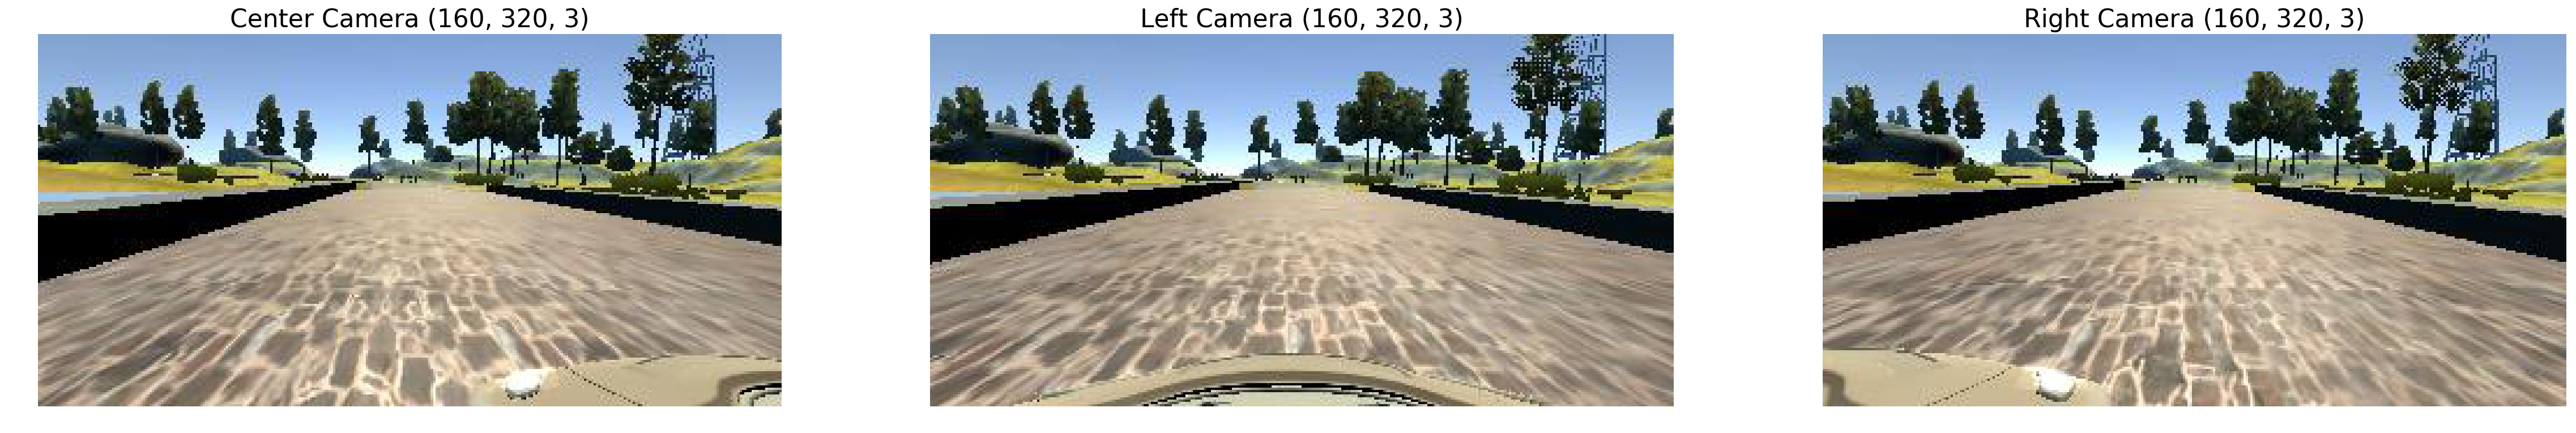

Labels
	- Steering: 0.0


In [272]:
show_sample(dataset[0])

**Step 2**: Show streering angle histograms

/home/adrian/anaconda3/envs/self-driving-car-model/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


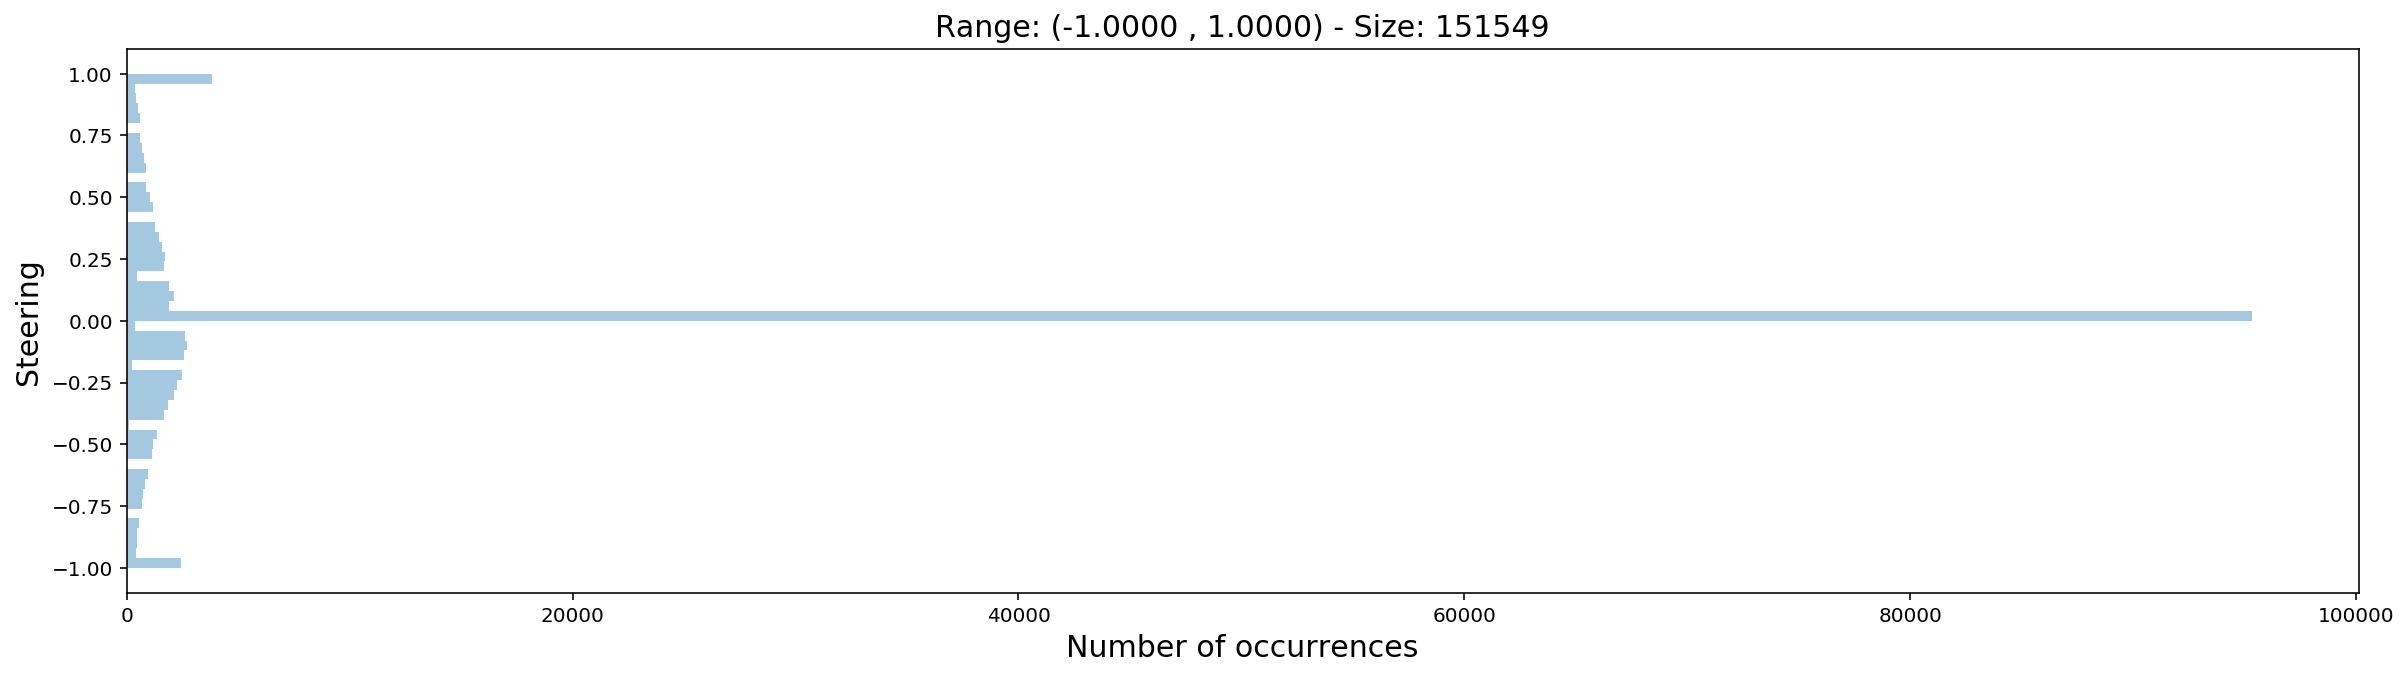

In [273]:
dataset.show_labels_stats()

**Note that** the vast manjority of samples are close to zero (similar to a normal distribution). This is not a desired feature, think that this mean cause that the car would learn to keep in straight line.

**Step 2**: Split dataset in train and validation.

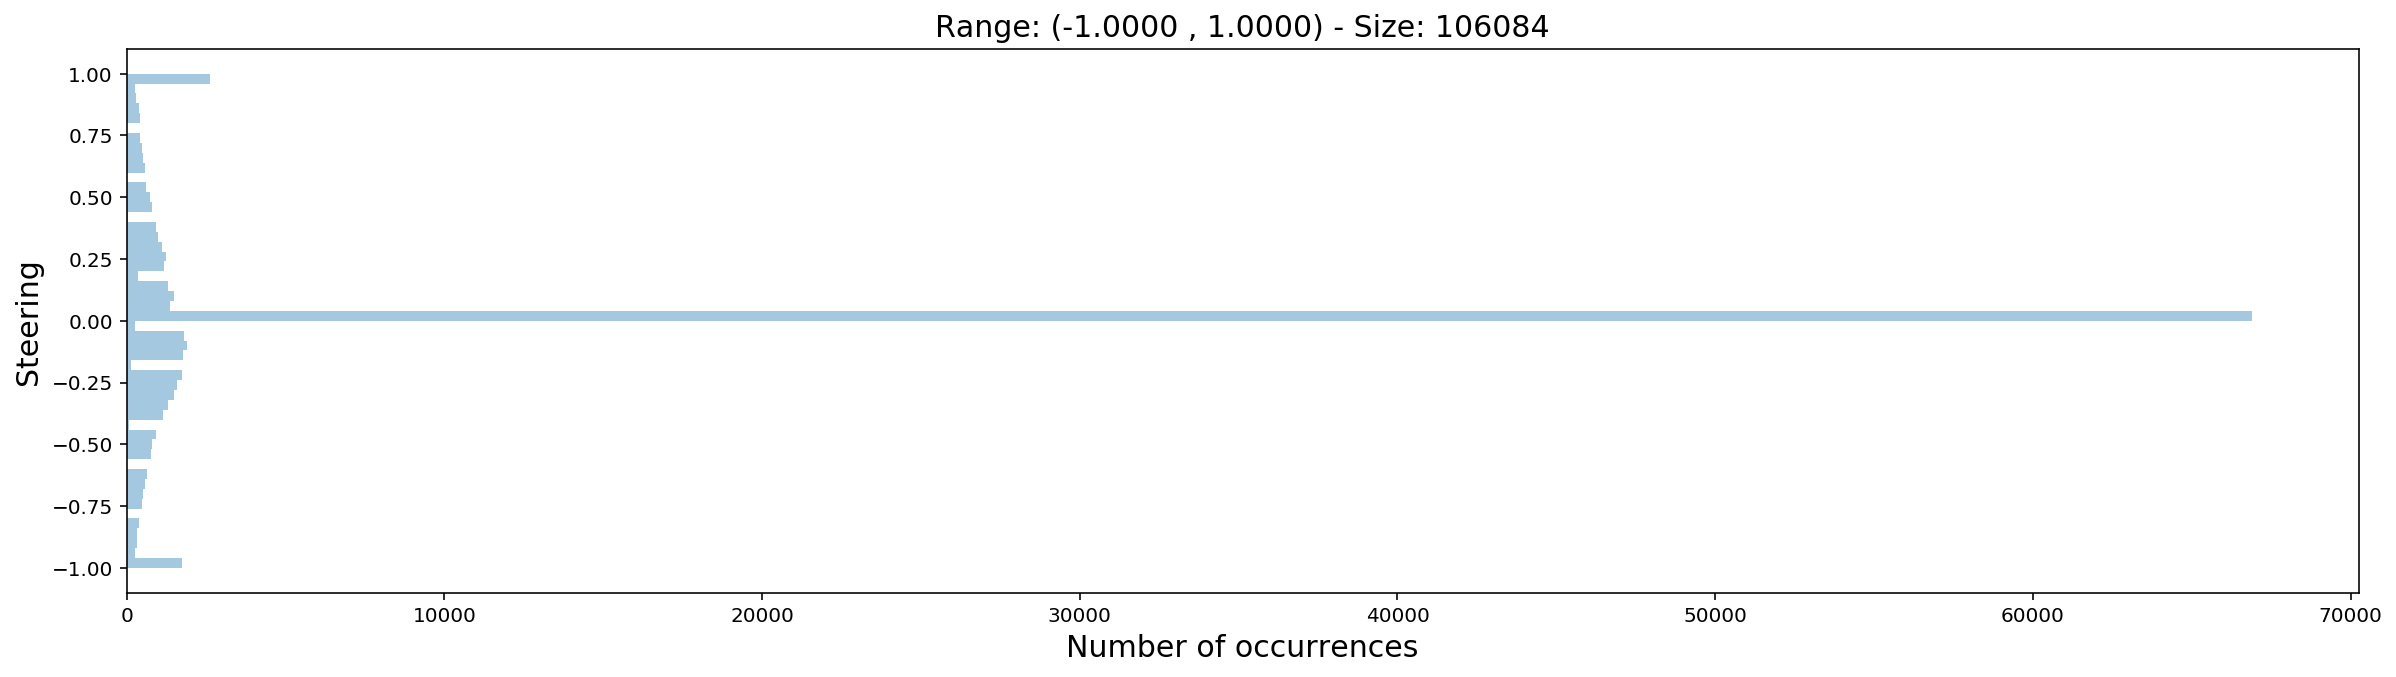

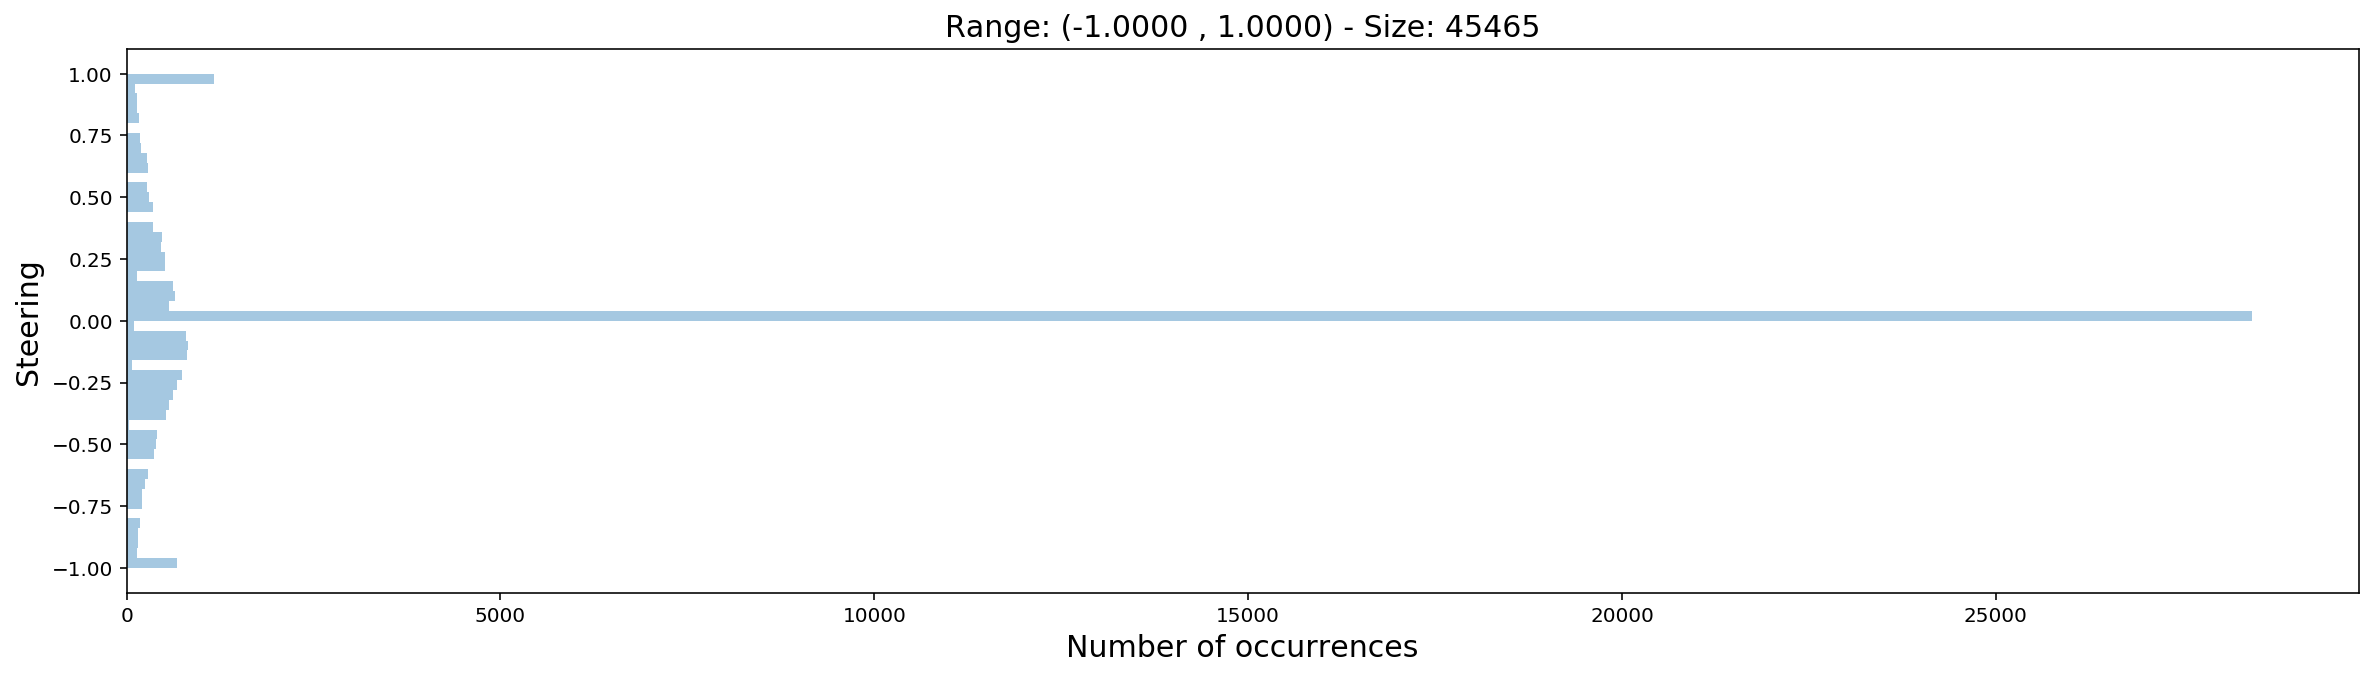

In [274]:
train_dataset, validation_dataset = dataset.split(percent=cfg['train']['validation_set_percent'], shuffle=True)
train_dataset.show_labels_stats()
validation_dataset.show_labels_stats()

### Data generation process

After all is necessary explain three importante points:

* A generator allow us to generator a dataset for augment and/or preprocess and in this way increase samples amount. 
* Since in most cases dataset does not fit in memory a generator allow as to save memory space, loading only a subset of this on each train batch.
* A generator also allow us to process data using multiples cpu cores.

On the other hand, data augmentation and preprocessing is required to improve model accuracy. Particularly for this problem is required two flows to generate samples:

* **Train samples generation**:
    * Augment & preprocess a randomly image from the center, left or right cameras.
    * Preproress agmented image.
    * Steering angles is adjustes in each case.

* **Validation samples generation**: Only preprocess center camera image.

But what does augmentation and preprocess means?
        
* **Augmentation steps**: 
    1. Randomly choose an image from the center, left or right, and adjust the steering angle.
    2. Randomly flip the image left <-> right, and adjust the steering angle.
    3. Randomly shift the image vertically and horizontally (translation).
    4. Generates and adds random shadow.
    5. Randomly adjust brightness of the image.

* **Preprocessing steps**:
    1. Crop the image (removing the sky at the top and the car front at the bottom).
    2. Resize the image to the input shape used by the network model.
    3. Convert the image from RGB to YUV (This is what the NVIDIA model does).

#### Augmentation steps

Let's get a sample to show each augmentation effect.

Features
	- Center: datasets/dataset_16/IMG/center_2018_12_08_11_19_45_391.jpg
	- Left: datasets/dataset_16/IMG/left_2018_12_08_11_19_45_391.jpg
	- Right: datasets/dataset_16/IMG/right_2018_12_08_11_19_45_391.jpg
	- Images:


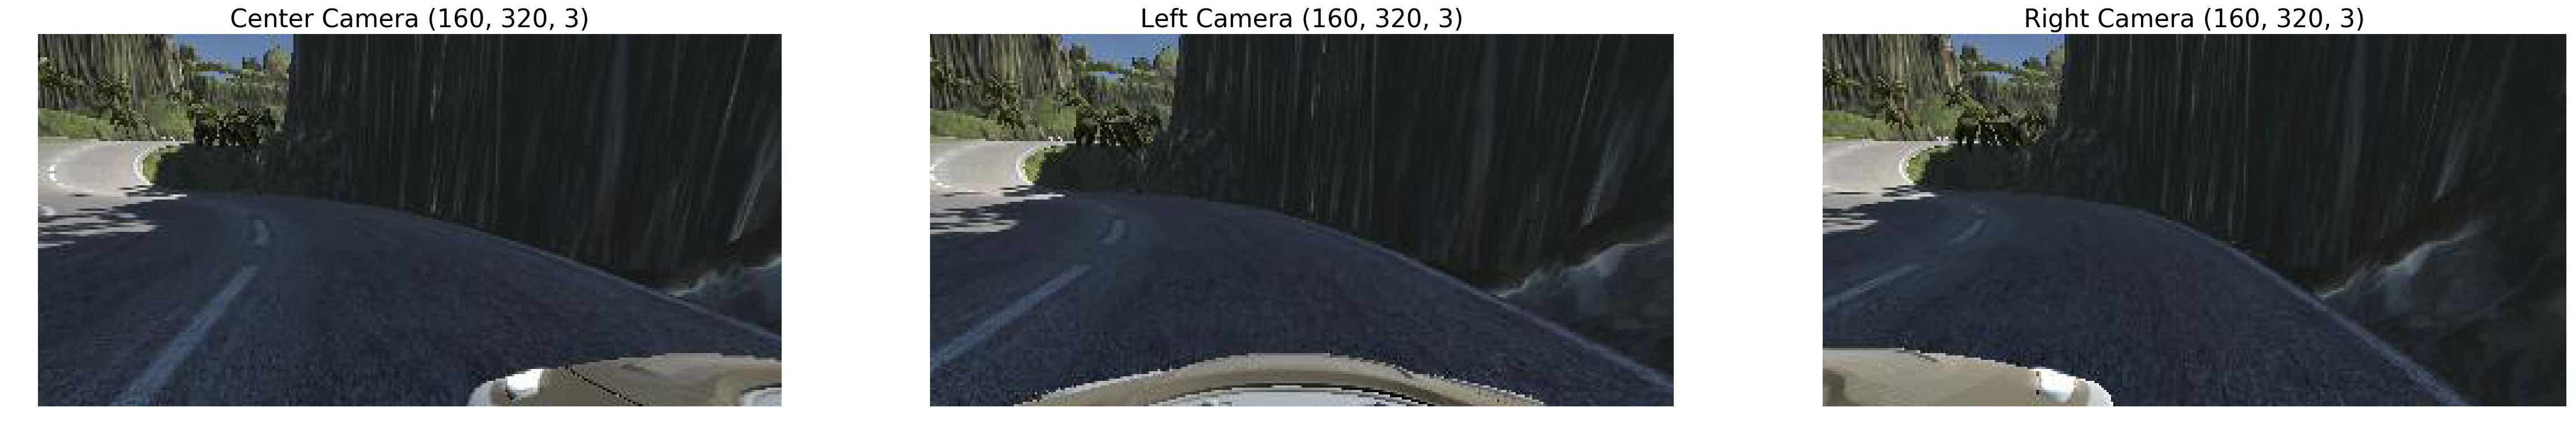

Labels
	- Steering: -0.9000002


In [275]:
sample = dataset.shuffle()[0]
show_sample(sample)

**Randomly choose an image**: From the center, left or right, and adjust
    the steering angle.

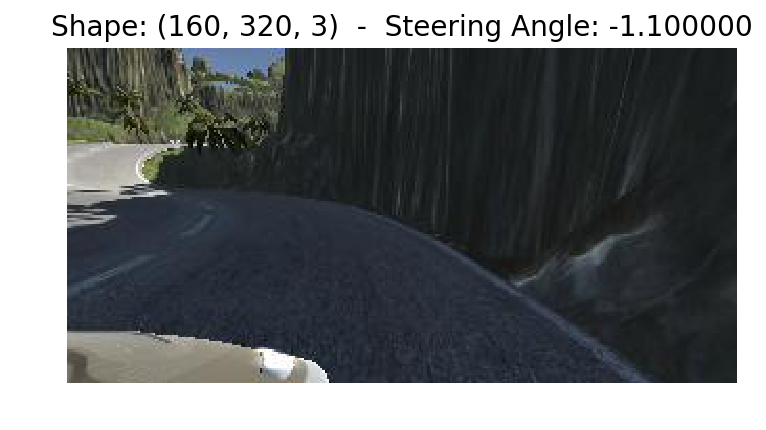

In [276]:
img, angle = choose_image(
    sample.feature('center'),
    sample.feature('left'),
    sample.feature('right'),
    sample.label('steering'),
    adjustment_angle=0.2
)
show_sample_data(img, angle)

**Randomly flip image**: Randomly flip the image left <-> right, and adjust the steering angle.

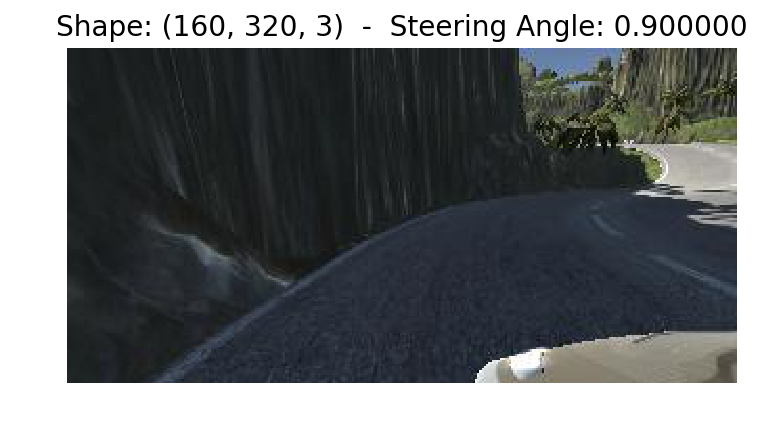

In [277]:
img, angle = random_image_flip(sample.feature_image('right'), sample.label('steering'))
show_sample_data(img, angle)

**Randomly translate**: Randomly shift the image vertically and horizontally.

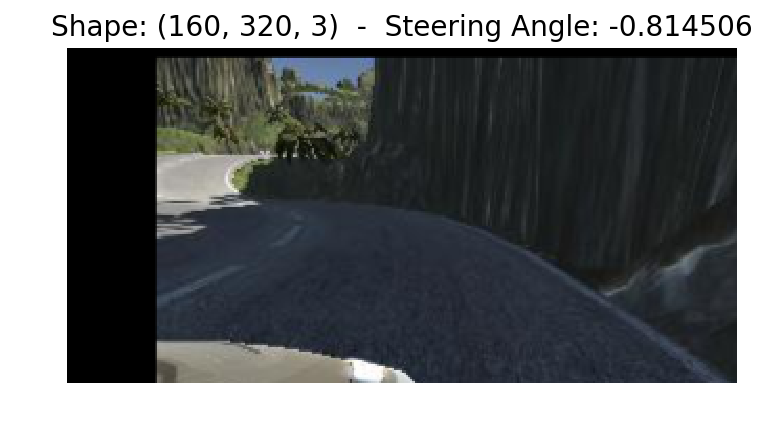

In [278]:
img, angle = random_image_translate(
    sample.feature_image('right'), 
    sample.label('steering'),
    range_x=100, 
    range_y=10,
    angle_delta=0.002
)
show_sample_data(img, angle)

**Random shadow**: Generates and adds random shadow.

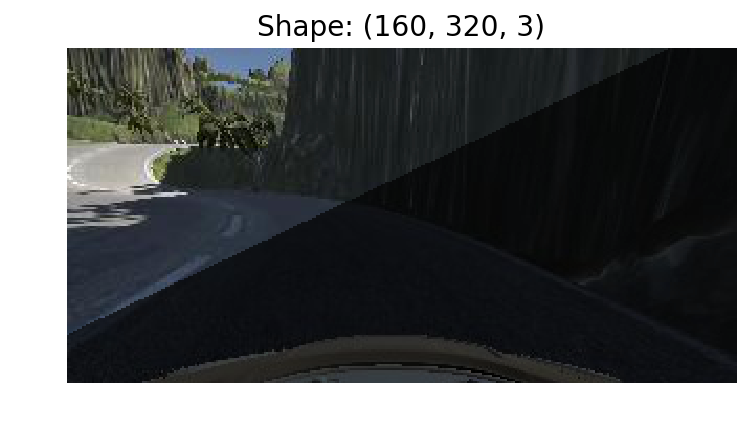

In [279]:
show_sample_data(random_image_shadow(sample.feature_image('center'), width=320, height=160))

**Randomly brightness**: Randomly adjust brightness of the image.

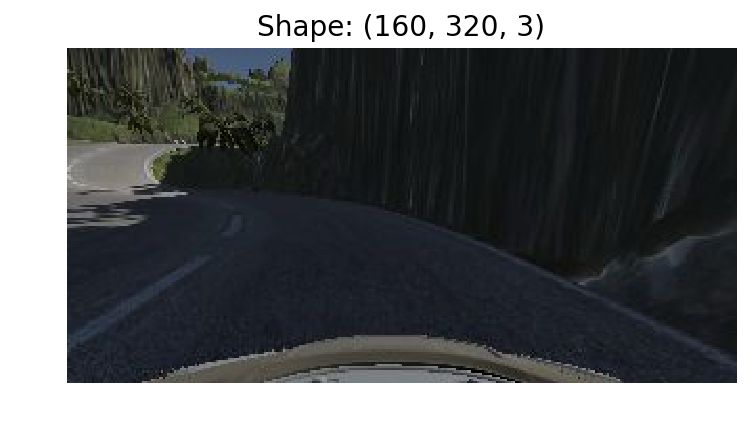

In [280]:
show_sample_data(random_image_brightness(sample.feature_image('center')))

#### Preprocessing steps

Let's get a samples centrar image to show each preprocessing step:

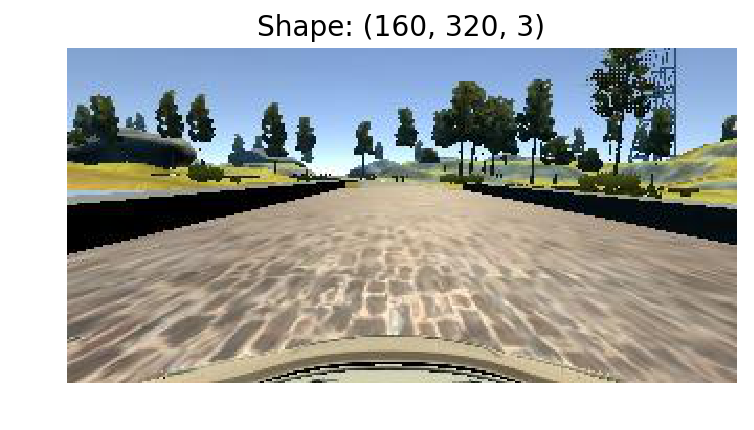

In [281]:
image = load_image(dataset[0].features[0])
show_sample_data(image)

**Step 1:** Randomly choose an image from the center, left or right, and adjust the steering angle.

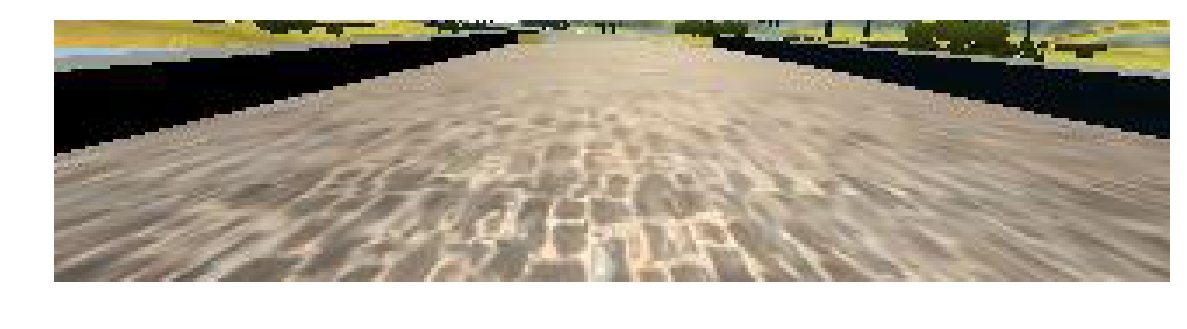

In [282]:
choped_image = vertical_crop_image(image, top_offset=60, bottom_offset=25)
show_image(choped_image)

**Step 2**: Resize the image to the input shape used by the network model.

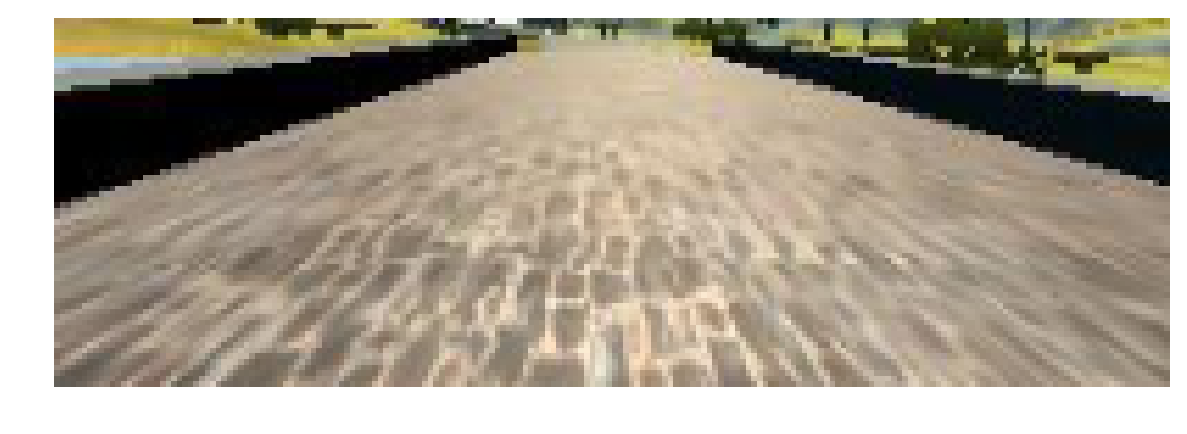

In [283]:
resized_image = resize_image(choped_image, 200, 66)
show_image(resized_image)

**Step 3**: Convert the image from RGB to YUV (This is what the NVIDIA model does).

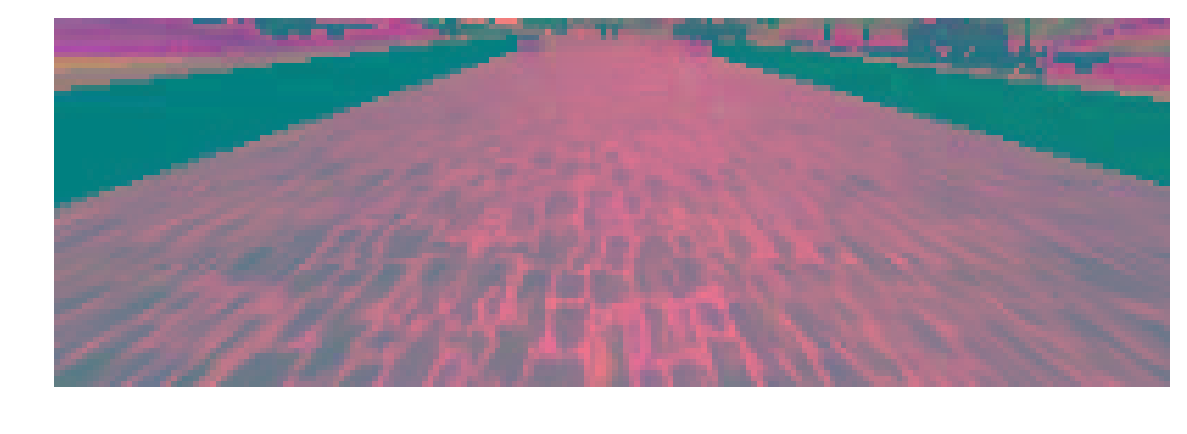

In [284]:
show_image(rgb_to_yuv(resized_image))

#### Create train and validation data generators

In [285]:
image_input_shape = (
    cfg['network']['image_input_shape']['height'],
    cfg['network']['image_input_shape']['width'],
    cfg['network']['image_input_shape']['channels']
)
input_shapes=[image_input_shape]
output_shape=(1,)

print("Inputs Shapes:", image_input_shape)
print("Ouput Shape:", output_shape)

Inputs Shapes: (66, 200, 3)
Ouput Shape: (1,)


In [286]:
batch_size = cfg['train']['batch_size']
augment_threshold = cfg['train']['augment']['threshold']
choose_adjustment_angle =  cfg['train']['augment']['choose_adjustment_angle']
translate_range_x = cfg['train']['augment']['translate_range_x']
translate_range_y = cfg['train']['augment']['translate_range_y']
translate_angle_delta = cfg['train']['augment']['translate_angle_delta']
top_offset=cfg['train']['preprocess']['crop']['top_offset']
bottom_offset=cfg['train']['preprocess']['crop']['bottom_offset']
steer_threshold=cfg['train']['augment']['throttle']['steer_threshold']
speed_threshold=cfg['train']['augment']['throttle']['speed_threshold']
throttle_delta=cfg['train']['augment']['throttle']['throttle_delta']
choose_image_adjustment_angle=cfg['train']['augment']['choose_image_adjustment_angle']
image_translate_angle_delta=cfg['train']['augment']['image_translate_angle_delta']

In [287]:
print("Number of samples by batch: ", batch_size)
print("Image augment threshold: ", augment_threshold)
print("Adjusment angle delta when choose an image: ", choose_adjustment_angle)
print("Image translate x range: ", translate_range_x)
print("Image translate y range: ", translate_range_y)
print("Image translate angles delta: ", translate_angle_delta)
print("Image crop top offset: ", top_offset)
print("Image crop bottom offset: ", bottom_offset)
print("Steer threshold: ", steer_threshold)
print("speed threshold ", speed_threshold)
print("Throttle delta: ", throttle_delta)
print("Choose image adjustment angle: ", choose_image_adjustment_angle)
print("Image translate angle delta: ", image_translate_angle_delta)

Number of samples by batch:  100
Image augment threshold:  0.6
Adjusment angle delta when choose an image:  0.25
Image translate x range:  100
Image translate y range:  10
Image translate angles delta:  0.0035
Image crop top offset:  55
Image crop bottom offset:  25
Steer threshold:  0.5
speed threshold  20
Throttle delta:  0.3
Choose image adjustment angle:  0.2
Image translate angle delta:  0.002


In [288]:
image_preprocessor = ImagePreprocessor(top_offset, bottom_offset, image_input_shape)

In [289]:
train_augmenter = SampleAugmenter(
    image_preprocessor,
    augment_threshold,
    translate_range_x, 
    translate_range_y,
    choose_image_adjustment_angle,
    image_translate_angle_delta,        
    steer_threshold,
    speed_threshold,
    throttle_delta
)

In [290]:
train_generator = DataGenerator(
    train_dataset,
    input_shapes,
    output_shape,
    batch_size,
    train_augmenter,
    shuffle_per_epoch=True
)

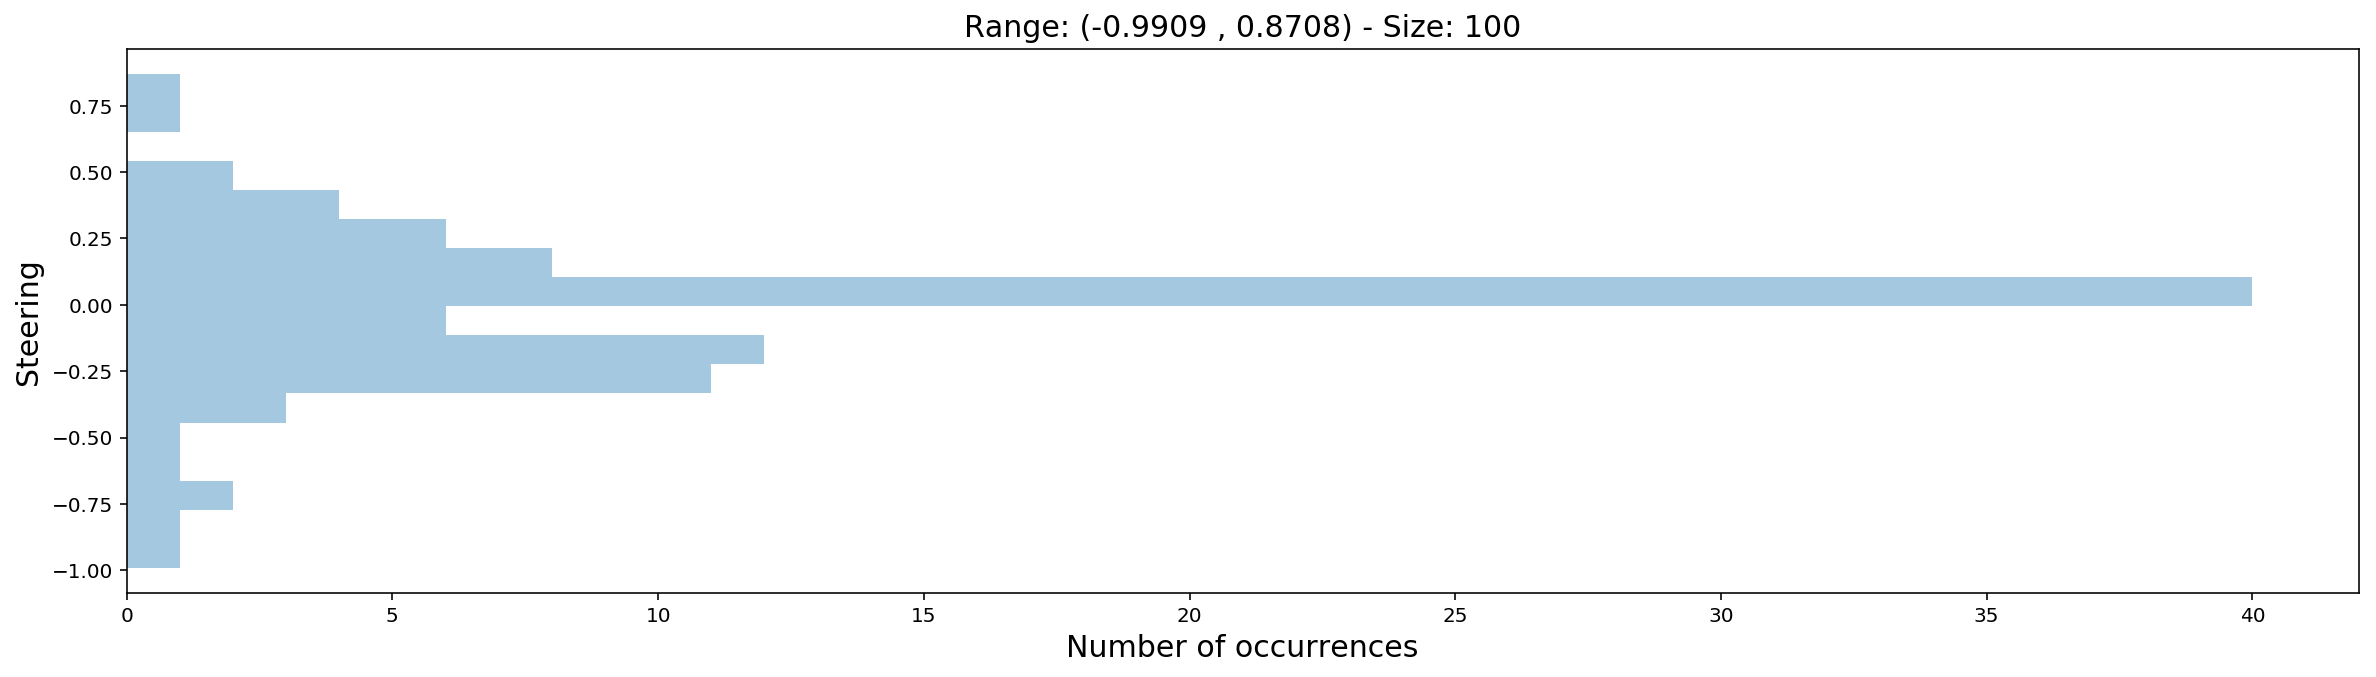

In [291]:
train_generator.any_batch().show_labels_stats()

In [292]:
validation_augmenter = NullSampleAugmenter(image_preprocessor)

In [293]:
validation_generator = DataGenerator(
    validation_dataset,
    input_shapes,
    output_shape,
    batch_size,
    validation_augmenter,
    shuffle_per_epoch=False
)

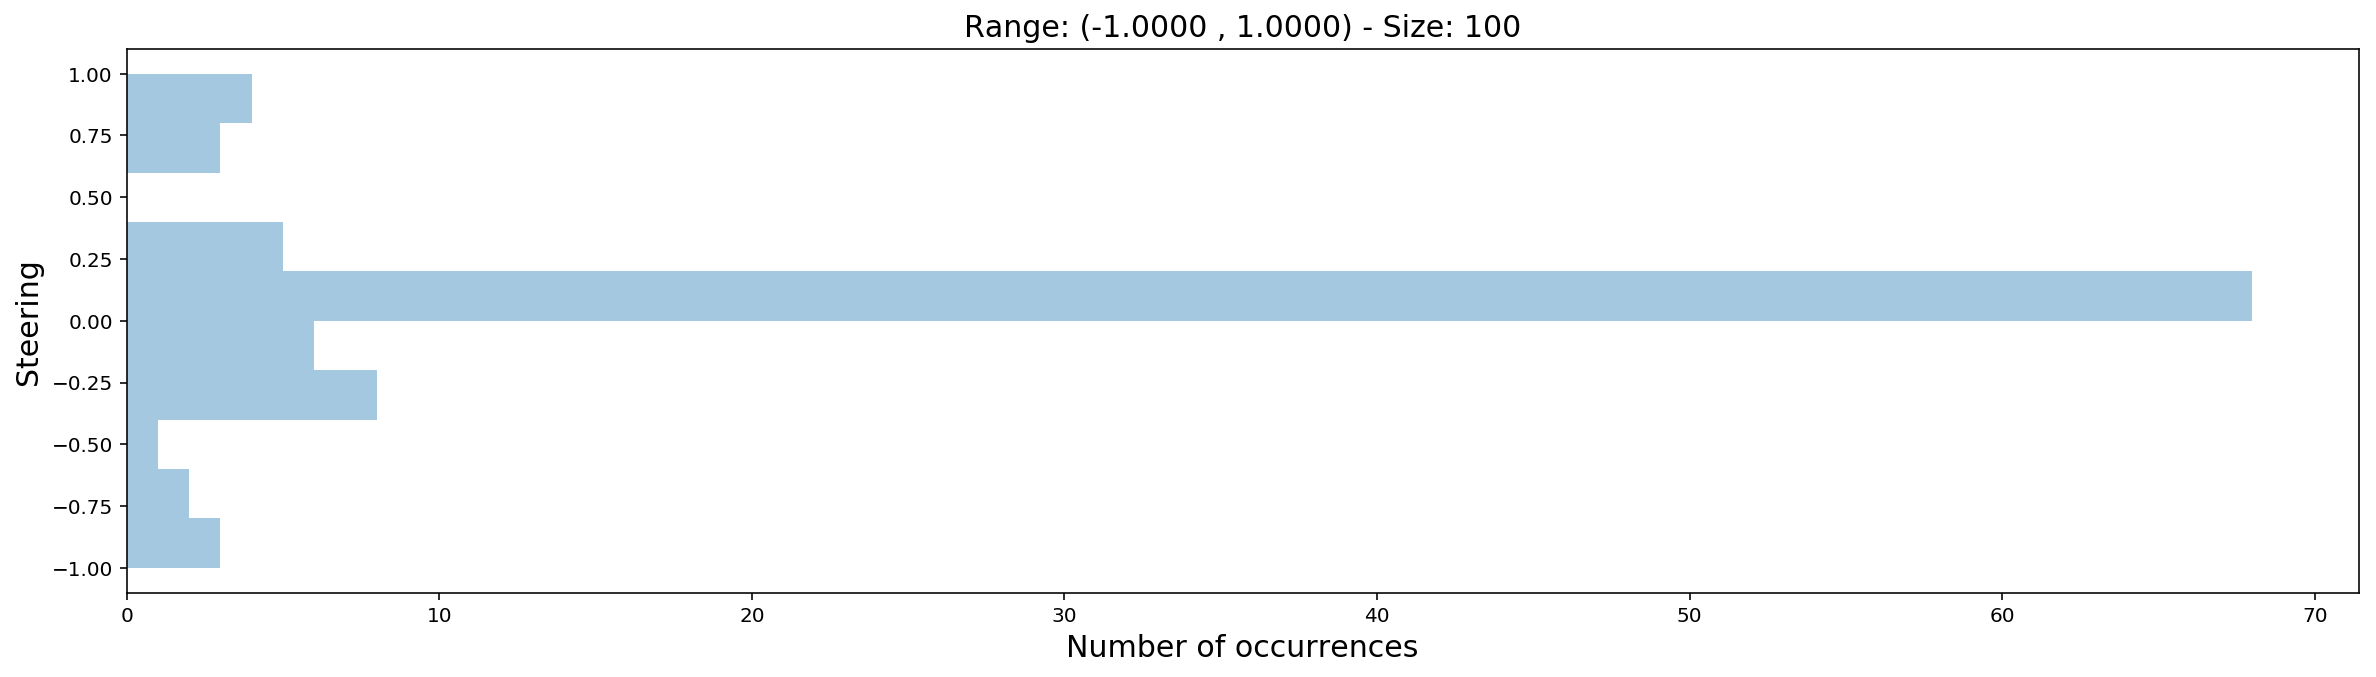

In [294]:
validation_generator.any_batch().show_labels_stats()

### Create NVidia model




MODEL LAYERS

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
utils (InputLayer)           (None, 66, 200, 3)        0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
batch_normalization_19 (Batc (None, 31, 98, 24)        96        
_________________________________________________________________
conv_2 (Conv2D)              (None, 14, 47, 36)        21636     
_________________________________________________________________
batch_normalization_20 (Batc (None, 14, 47, 36)        144       
_________________________________________________________________
conv_3 (Conv2D)              (None, 5, 22, 48)         4324

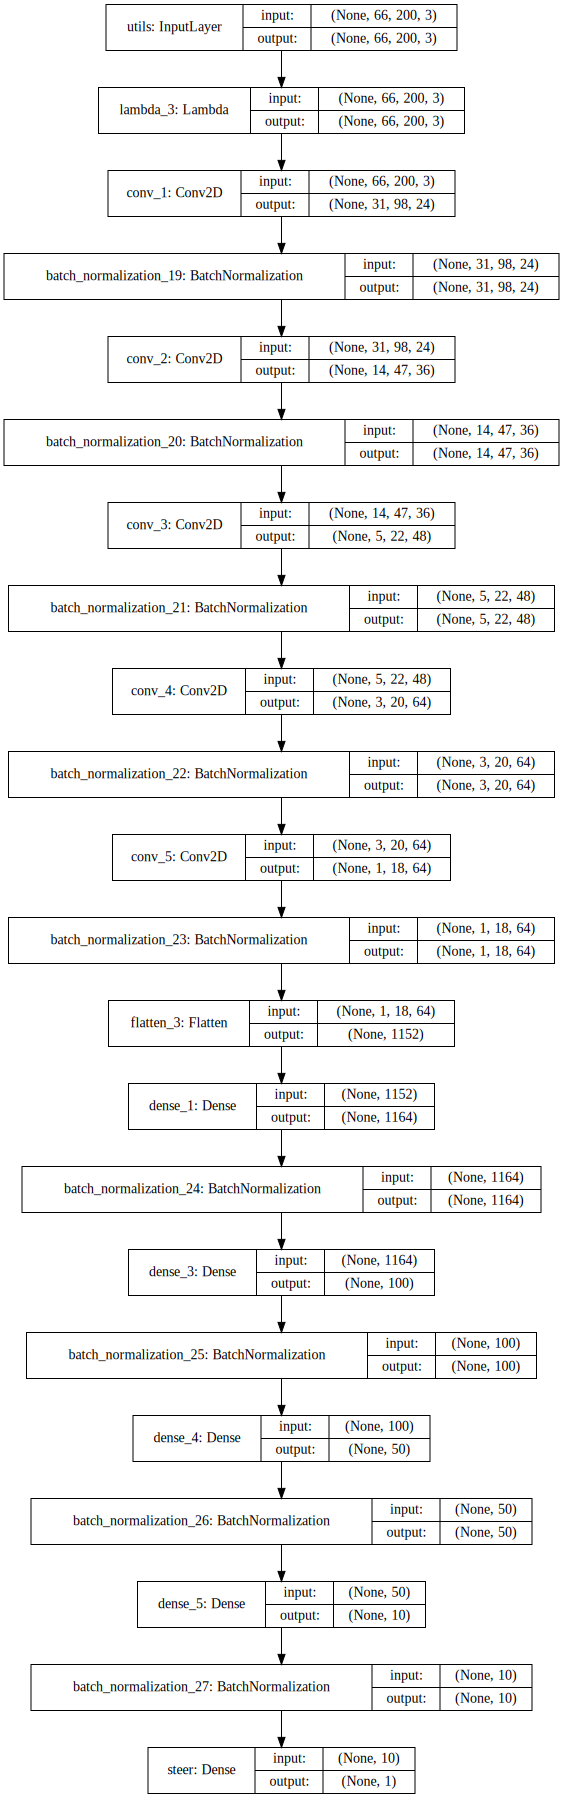

In [295]:
activation  = 'relu'
loss        = 'mean_squared_error'
metrics     = [rmse]
optimizer   = Adam(lr=0.001)

model = ModelFactory.create_nvidia_model(activation, loss, metrics, optimizer)

model.show()

In [296]:
last_weights_file_path = last_created_file_from("checkpoints/*.h5")
print(f'last_weights_file_path: {last_weights_file_path}')

last_weights_file_path: checkpoints/weights__epoch_14__loss_0.0478__rmse_0.2021.h5


In [297]:
model.load_weights(last_weights_file_path)

### Train Model

**Steps per epoch**: Total number of steps (batches of samples) to yield from generator before declaring one epoch finished and starting the next epoch.

**samples_per_epoch = train_samples / batch_size**


In [298]:
steps_per_epoch = int(len(train_dataset)/batch_size)
epochs          = 25

print("- Epochs: ", epochs)
print("- Batches per epoch: ", steps_per_epoch)

- Epochs:  25
- Batches per epoch:  1060


In [299]:
monitor_metric = 'val_rmse'

'''
    ReduceLROnPlateau(
        monitor  = monitor_metric,
        factor   = 0.2,
        patience = 2
    ),
    LRScheduler({ 12: 0.0001, 12: 0.00001 }, verbose=1)
'''

callbacks = [
    CheckpointFactory(
        path = cfg['train']['checkpoint_path']
    ).create(
        metric = monitor_metric
    ),
    EarlyStopping(
        monitor  = monitor_metric,
        patience = 4
    ),
    MetricsPlotter(
        validation_generator, 
        plot_interval     = 50,  
        evaluate_interval = 50
    ),
    AdamLearningRateTracker(
        evaluate_interval = 50
    )
]

In [243]:
model.train(train_generator, validation_generator, steps_per_epoch, epochs, callbacks)

### Test Model

In [300]:
dataset = loader.load(
    features = cfg['dataset']['features'],
    labels   = cfg['dataset']['labels'],
    mode     = 'test'
)

dataset(814) loadded /home/adrian/development/machine-learning/self-driving-car-model/datasets/dataset_0/driving_log.csv 
dataset(3538) loadded /home/adrian/development/machine-learning/self-driving-car-model/datasets/dataset_1/driving_log.csv 


In [301]:
test_generator = DataGenerator(
    dataset,
    input_shapes,
    output_shape,
    len(dataset),
    validation_augmenter,
    shuffle_per_epoch=False
)
features, labels = test_generator[0]

In [302]:
last_weights_file_path = last_created_file_from("checkpoints/*.h5")
print(f'last_weights_file_path: {last_weights_file_path}')

model.load_weights(last_weights_file_path)

last_weights_file_path: checkpoints/weights__epoch_14__loss_0.0478__rmse_0.2021.h5


In [303]:
model.evaluate(features, labels, verbose=1)

4352/4352 [==============================] - 1s 263us/step

- loss: 0.01502209996102893
- rmse: 0.10647828418158871



[0.01502209996102893, 0.10647828418158871]

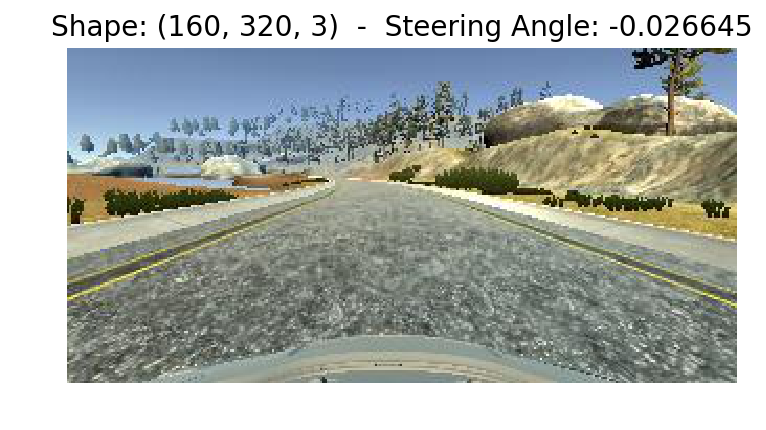

In [312]:
import numpy as np

sample = dataset[0]
image  = image_preprocessor.process(sample.feature_image('center'))

prediction = model.predict(np.array([image]))

show_sample_data(sample.feature_image('center'), prediction[0][0])